In [1]:
class TempArgs:
    pass
args = TempArgs()
args.dataset = 'cervix93_zstacks'
args.image_size = 512
args.method = 'EDOF_CNN_pack_43'
args.Z = 5
args.fold = 0
args.epochs = 200
args.batchsize = 4
args.lr = 1e-3
args.cudan = 0
args.image_channels = 'grayscale'
args.automate = 1
args.augmentation = 0
args.augmentLevel = 0
args.rotate = 0
args.hflip = 0
args.ssim = 0
args.jitter = 0
args.comment = '' 

In [17]:
import numpy as np
from time import time
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
import torch
import dataset, models
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from skimage.exposure import match_histograms


device = torch.device('cuda:'+str(args.cudan) if torch.cuda.is_available() else 'cpu')

#define transforms if rgb or not
test_transform=dataset.val_transforms
train_transformY=dataset.val_transforms
test_transformY=dataset.val_transforms

def test(val, model):
    model.eval()
    avg_loss_val = 0
    with torch.no_grad():
        for XX, Y in val:
            XX = [X.to(device, torch.float) for X in XX]
            Y = Y.to(device, torch.float)
            Yhat = model(XX)
            loss = model.loss(Yhat, Y.to(torch.float))
            avg_loss_val += loss / len(val)
    return avg_loss_val

def loadModel(image_channel):
    model = models.EDOF_CNN_pack_43()
    if (args.comment in ['grayscale','uintimg','colortransfer','colortransferFromInput']):
        model.load_state_dict(torch.load("dataset-fraunhofer_elastic_only-image_size-512-method-"+args.method+"-Z-"+str(args.Z)+"-fold-"+str(args.fold)+"-epochs-"+str(args.epochs)+"-batchsize-"+str(args.batchsize)+"-lr-0.001-cudan-0-image_channels-"+image_channel+"-automate-1-augmentation-0-augmentLevel-0-rotate-0-hflip-0-ssim-0"+".pth"))
    else:
        model.load_state_dict(torch.load("dataset-fraunhofer_elastic_only-image_size-512-method-"+args.method+"-Z-"+str(args.Z)+"-fold-"+str(args.fold)+"-epochs-"+str(args.epochs)+"-batchsize-"+str(args.batchsize)+"-lr-0.001-cudan-0-image_channels-"+image_channel+"-automate-1-augmentation-0-augmentLevel-0-rotate-0-hflip-0-ssim-0"+"-jitter-"+str(args.jitter)+"-comment-"+str(args.comment)+".pth"))
    model = model.to(device)
    return model

# print some metrics 
def predict_metrics(data, model):
    model.eval()
    Phat = []
    Y_true=[]
    input_list =[]
    with torch.no_grad():
        for XX, Y in data:
            XX = [X.to(device, torch.float) for X in XX]
            Y = Y.to(device, torch.float)
            Yhat = model(XX)
            # print(Yhat.shape)
            Phat += list(Yhat.cpu().numpy())
            Y_true += list(Y.cpu().numpy())
            numpy_list= []
            for x in XX:
                numpy_list+= list(x.cpu().numpy())
            input_list.append(numpy_list)
    return Y_true, Phat, input_list

prefix = '-'.join(f'{k}-{v}' for k, v in vars(args).items())
print(prefix)
    ############################# data loaders #######################################

ts_ds = dataset.Dataset('test', dataset.val_transforms, args.dataset, args.Z, args.fold, dataset.val_transforms, dataset.common_transform_empty)

model = models.EDOF_CNN_pack_43()
# model.load_state_dict(torch.load("dataset-fraunhofer_elastic_only-image_size-512-method-"+args.method+"-Z-"+str(args.Z)+"-fold-"+str(args.fold)+"-epochs-"+str(args.epochs)+"-batchsize-"+str(args.batchsize)+"-lr-0.001-cudan-0-image_channels-"+str(args.image_channels)+"-automate-1-augmentation-0-augmentLevel-0-rotate-0-hflip-0-ssim-0"+".pth"))
model = model.to(device)

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, normalized_root_mse 


data_test = DataLoader(ts_ds, 1,False,  pin_memory=True)
Y_true, Phat, X_list = predict_metrics(data_test,model)

import colortrans

# if (args.comment in ['uintimg','colortransfer','colortransferFromInput']):
#         # Phat = list(map(normalize8,Phat))
#         # Y_true = list(map(normalize8,Y_true))
#     if (args.comment in ['colortransfer','colortransferFromInput']):
#         color_transfered = []
#         if (args.comment == 'colortransfer'):
#             ref_list = Y_true
#         elif (args.comment == 'colortransferFromInput'):
#             temp_list = []
#             for x in X_list:
#                 #     my_mean = np.array(x)
#                 #     my_mean = np.mean(my_mean, axis= 0, dtype=np.uint8)
#                 temp_list.append(x[0])
#                 # temp_list = list(map(normalize8,temp_list))
#             ref_list = temp_list
#         for pred, ref in zip(Phat, ref_list):
#             pred_reshape = np.moveaxis(pred,0,2)
#             ref_reshape = np.moveaxis(ref,0,2)
#             matched_histogram = match_histograms(pred_reshape, ref_reshape,channel_axis=-1)
#                 # col_transfered = colortrans.transfer_lhm(pred_reshape, ref_reshape)
#             resume_shape = np.moveaxis(matched_histogram,2,0)
#             color_transfered.append(resume_shape)
#         Phat = color_transfered

mse = np.mean([mean_squared_error(Y_true[i], Phat[i]) for i in range(len(Y_true))])
rmse = np.mean([normalized_root_mse(Y_true[i], Phat[i]) for i in range(len(Y_true))])
    # if (args.comment in ['uintimg', 'colortransfer','colortransferFromInput']):
    #     ssim =np.mean([ssim(Y_true[i], Phat[i],channel_axis=0,data_range=255) for i in range(len(Y_true))]) 
    # else:
ssim =np.mean([ssim(Y_true[i], Phat[i],channel_axis=0,data_range=1) for i in range(len(Y_true))]) 
psnr =np.mean([peak_signal_noise_ratio(Y_true[i], Phat[i]) for i in range(len(Y_true))])




# f = open('my_results_fixed_2/'+ str(prefix)+'.txt', 'w')
# f.write('\n\nModel:'+str(prefix)+
    # ' \nMSE:'+ str(mse)+
    # ' \nRMSE:'+ str(rmse)+
    # ' \nSSIM:'+str(ssim)+
    # ' \nPSNR:'+ str(psnr))
# f.close()

print('my_results_fixed_1/'+ str(prefix)+'.txt')


dataset-cervix93_zstacks-image_size-512-method-EDOF_CNN_pack_43-Z-5-fold-0-epochs-200-batchsize-4-lr-0.001-cudan-0-image_channels-grayscale-automate-1-augmentation-0-augmentLevel-0-rotate-0-hflip-0-ssim-0-jitter-0-comment-
my_results_fixed_1/dataset-cervix93_zstacks-image_size-512-method-EDOF_CNN_pack_43-Z-5-fold-0-epochs-200-batchsize-4-lr-0.001-cudan-0-image_channels-grayscale-automate-1-augmentation-0-augmentLevel-0-rotate-0-hflip-0-ssim-0-jitter-0-comment-.txt


In [19]:
pic_order = 10
predicted = Phat[pic_order]
gt = Y_true[pic_order]
input_im = X_list[pic_order]

predicted = np.moveaxis(predicted,0,2)
gt = np.moveaxis(gt,0,2)
for i in range(5):
    input_im[i] = np.moveaxis(input_im[i],0,2)

In [20]:
X_list[pic_order][0].shape

(512, 512, 1)

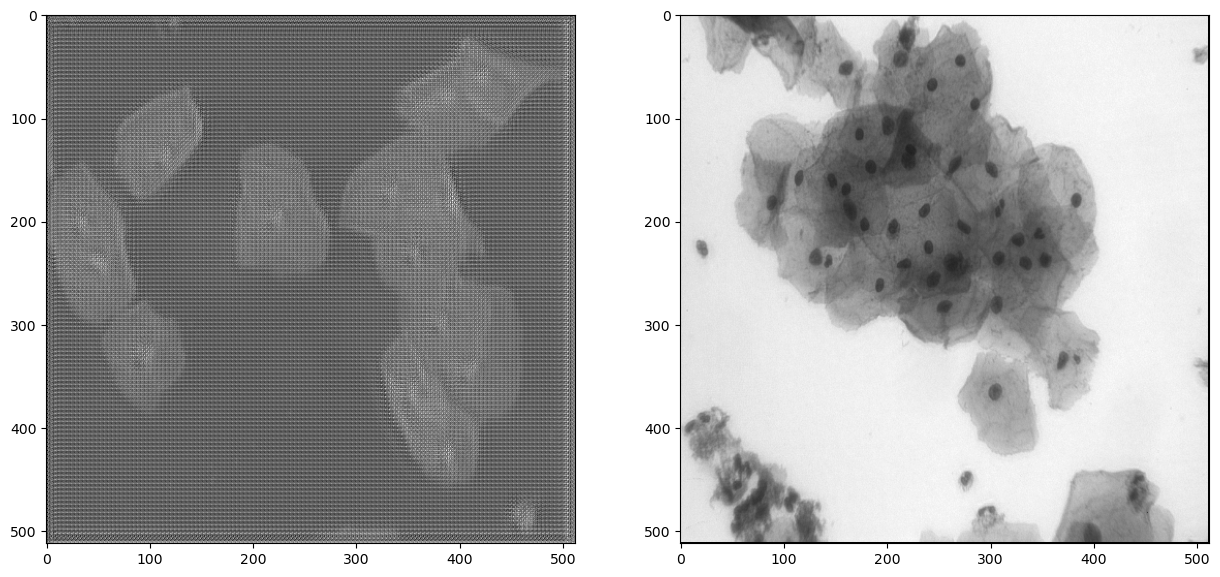

In [8]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(predicted, cmap='gray')
axs[1].imshow(gt, cmap='gray')


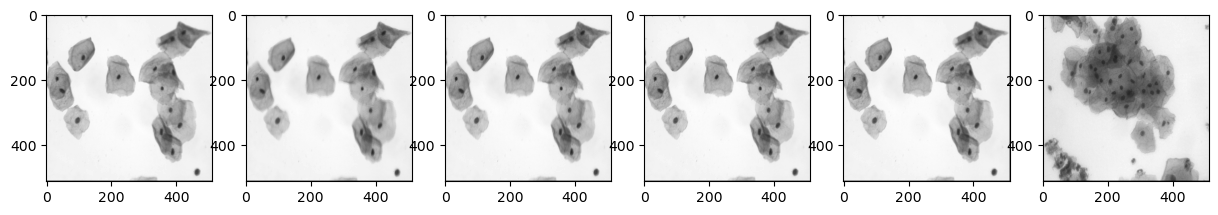

In [21]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 6, figsize=(15, 15))
axs[0].imshow(input_im[0], cmap='gray')
axs[1].imshow(input_im[1], cmap='gray')
axs[2].imshow(input_im[2], cmap='gray')
axs[3].imshow(input_im[3], cmap='gray')
axs[4].imshow(input_im[4], cmap='gray')
axs[5].imshow(gt, cmap='gray')

In [5]:
from matplotlib import pyplot as plt

pic_order = 10
predicted = Phat[pic_order]
gt = Y_true[pic_order]
input_im = X_list[pic_order][0]

predicted = np.moveaxis(predicted,0,2)
gt = np.moveaxis(gt,0,2)
input_im = np.moveaxis(input_im,0,2)

histogram_matched = match_histograms(predicted, input_im,channel_axis=0)

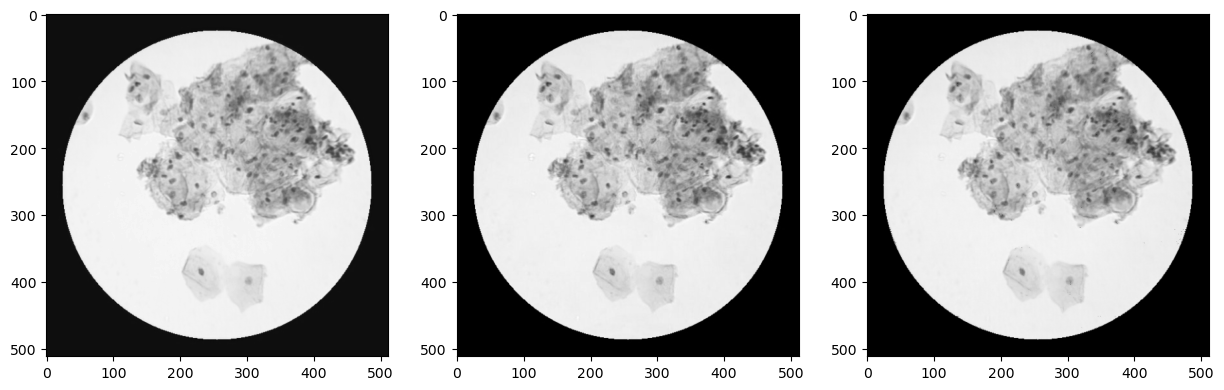

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(predicted, cmap='gray')
axs[1].imshow(gt, cmap='gray')
axs[2].imshow(histogram_matched, cmap='gray')